<a href="https://colab.research.google.com/github/MatveyOreshkinn/Minor/blob/main/%D0%9B%D0%A01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import re

from google.colab import drive
import warnings


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
log_pattern = r'(\S+) - - \[(.*?)\] "(\S+) (\S+) (\S+\s\S+)" (\d+) (\d+) (\S+)'
# Создаем пустой список для хранения распарсенных данных
parsed_data = []

# Открываем файл и читаем построчно
with open('/content/drive/MyDrive/access.log', 'r') as file: # Убедитесь, что указали правильный путь к файлу
    for line in file:
        # Ищем совпадения с нашим шаблоном в каждой строке
        match = re.match(log_pattern, line)
        if match:
            # Если строка соответствует шаблону, извлекаем группы
            parsed_data.append(match.groups())

# Определяем названия колонок для будущего DataFrame
column_names = ['ip', 'timestamp', 'http_method', 'endpoint', 'http_version', 'status_code', 'response_size', 'session_id']

# Создаем DataFrame
df = pd.DataFrame(parsed_data, columns=column_names)
df.head()

,ip,timestamp,http_method,endpoint,http_version,status_code,response_size,session_id
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,HTTP 1.1,200,4407,ID4887
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,HTTP 1.1,200,4025,ID4887
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,HTTP 1.1,200,3482,ID4887
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,HTTP 1.1,200,4904,ID4887
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,HTTP 1.1,200,2104,ID4887


In [196]:
df.describe()

,ip,timestamp,http_method,endpoint,http_version,status_code,response_size,session_id
count,239202,239202,239202,239202,239202,239202,239202,239202
unique,50850,239202,2,102,1,1,3000,50850
top,143.167.87.213,31/Jan/2015:23:59:57 +03:00,POST,/catalog.phtml,HTTP 1.1,200,4026,ID22347
freq,39,1,219864,110410,239202,239202,112,39


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239202 entries, 0 to 239201
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             239202 non-null  object
 1   timestamp      239202 non-null  object
 2   http_method    239202 non-null  object
 3   endpoint       239202 non-null  object
 4   http_version   239202 non-null  object
 5   status_code    239202 non-null  object
 6   response_size  239202 non-null  object
 7   session_id     239202 non-null  object
dtypes: object(8)
memory usage: 14.6+ MB


In [198]:
df['http_version'].value_counts()  # все версия протокола одинаковые

,count
http_version,
HTTP 1.1,239202


In [199]:
df['status_code'].value_counts()  # все ответы серверы были успешными

,count
status_code,
200,239202


In [200]:
df.drop(['http_version', 'status_code'], inplace=True, axis=1)

df.head()

,ip,timestamp,http_method,endpoint,response_size,session_id
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,4407,ID4887
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,4025,ID4887
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,3482,ID4887
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,4904,ID4887
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,2104,ID4887


In [201]:
df['http_method'].value_counts()

,count
http_method,
POST,219864
GET,19338


In [202]:
df['session_id'].value_counts()

,count
session_id,
ID22347,39
ID52666,35
ID21489,33
ID38085,33
ID13435,33
...,...
ID55685,1
ID55686,1
ID4831,1


# Кластеризация


In [203]:
# кодирование ip
df[['octet1', 'octet2', 'octet3', 'octet4']] = df['ip'].str.split('.', expand=True)

df.head()

,ip,timestamp,http_method,endpoint,response_size,session_id,octet1,octet2,octet3,octet4
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,4407,ID4887,179,203,10,126
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,4025,ID4887,179,203,10,126
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,3482,ID4887,179,203,10,126
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,4904,ID4887,179,203,10,126
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,2104,ID4887,179,203,10,126


In [204]:
# кодирование методов

encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['http_method']])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['http_method']))
df = pd.concat([df, encoded_df], axis=1)

df.head()

,ip,timestamp,http_method,endpoint,response_size,session_id,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,4407,ID4887,179,203,10,126,0.0,1.0
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,4025,ID4887,179,203,10,126,0.0,1.0
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,3482,ID4887,179,203,10,126,0.0,1.0
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,4904,ID4887,179,203,10,126,0.0,1.0
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,2104,ID4887,179,203,10,126,0.0,1.0


In [205]:
# Кодируем session_id
frequency_map = df['session_id'].value_counts().to_dict()
df['session_freq'] = df['session_id'].map(frequency_map)

df.head()

,ip,timestamp,http_method,endpoint,response_size,session_id,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,4407,ID4887,179,203,10,126,0.0,1.0,9
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,4025,ID4887,179,203,10,126,0.0,1.0,9
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,3482,ID4887,179,203,10,126,0.0,1.0,9
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,4904,ID4887,179,203,10,126,0.0,1.0,9
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,2104,ID4887,179,203,10,126,0.0,1.0,9


In [206]:
# Кодируем endpoint
frequency_map = df['endpoint'].value_counts().to_dict()
df['endpoint_freq'] = df['endpoint'].map(frequency_map)

df.head()

,ip,timestamp,http_method,endpoint,response_size,session_id,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq
0,179.203.10.126,1/Jan/2015:00:00:02 +03:00,POST,/catalog.phtml,4407,ID4887,179,203,10,126,0.0,1.0,9,110410
1,179.203.10.126,1/Jan/2015:00:00:13 +03:00,POST,/search.phtml,4025,ID4887,179,203,10,126,0.0,1.0,9,109454
2,179.203.10.126,1/Jan/2015:00:00:15 +03:00,POST,/search.phtml,3482,ID4887,179,203,10,126,0.0,1.0,9,109454
3,179.203.10.126,1/Jan/2015:00:00:24 +03:00,POST,/catalog.phtml,4904,ID4887,179,203,10,126,0.0,1.0,9,110410
4,179.203.10.126,1/Jan/2015:00:00:30 +03:00,POST,/search.phtml,2104,ID4887,179,203,10,126,0.0,1.0,9,109454


In [207]:
# кодируем timestamp

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z')


df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year


df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)


df['second_sin'] = np.sin(2 * np.pi * df['second'] / 60)
df['second_cos'] = np.cos(2 * np.pi * df['second'] / 60)


days_in_month = df['timestamp'].dt.days_in_month
df['day_sin'] = np.sin(2 * np.pi * df['day'] / days_in_month)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / days_in_month)


df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


df = df.drop(['hour', 'minute', 'second', 'day', 'month'], axis=1)
df.head()


,ip,timestamp,http_method,endpoint,response_size,session_id,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq,year,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,day_sin,day_cos,month_sin,month_cos
0,179.203.10.126,2015-01-01 00:00:02+03:00,POST,/catalog.phtml,4407,ID4887,179,203,10,126,0.0,1.0,9,110410,2015,0.0,1.0,0.0,1.0,2.079117e-01,9.781476e-01,0.201299,0.97953,0.5,0.866025
1,179.203.10.126,2015-01-01 00:00:13+03:00,POST,/search.phtml,4025,ID4887,179,203,10,126,0.0,1.0,9,109454,2015,0.0,1.0,0.0,1.0,9.781476e-01,2.079117e-01,0.201299,0.97953,0.5,0.866025
2,179.203.10.126,2015-01-01 00:00:15+03:00,POST,/search.phtml,3482,ID4887,179,203,10,126,0.0,1.0,9,109454,2015,0.0,1.0,0.0,1.0,1.000000e+00,2.832769e-16,0.201299,0.97953,0.5,0.866025
3,179.203.10.126,2015-01-01 00:00:24+03:00,POST,/catalog.phtml,4904,ID4887,179,203,10,126,0.0,1.0,9,110410,2015,0.0,1.0,0.0,1.0,5.877853e-01,-8.090170e-01,0.201299,0.97953,0.5,0.866025
4,179.203.10.126,2015-01-01 00:00:30+03:00,POST,/search.phtml,2104,ID4887,179,203,10,126,0.0,1.0,9,109454,2015,0.0,1.0,0.0,1.0,5.665539e-16,-1.000000e+00,0.201299,0.97953,0.5,0.866025


In [208]:
df.columns

Index(['ip', 'timestamp', 'http_method', 'endpoint', 'response_size',
       'session_id', 'octet1', 'octet2', 'octet3', 'octet4', 'http_method_GET',
       'http_method_POST', 'session_freq', 'endpoint_freq', 'year', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [209]:
# Масштабируем
scaler = StandardScaler()
df_scaled = df.copy()

features_to_scale = ['octet1', 'octet2', 'octet3', 'octet4', 'http_method_GET',
       'http_method_POST', 'session_freq', 'endpoint_freq', 'year', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'day_sin', 'day_cos', 'month_sin', 'month_cos']
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df_scaled.head()

,ip,timestamp,http_method,endpoint,response_size,session_id,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq,year,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,day_sin,day_cos,month_sin,month_cos
0,179.203.10.126,2015-01-01 00:00:02+03:00,POST,/catalog.phtml,4407,ID4887,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.312503,0.0,0.000503,1.410646,0.000673,1.414824,0.293772,1.381991,0.284151,1.37651,0.0,1.110223e-16
1,179.203.10.126,2015-01-01 00:00:13+03:00,POST,/search.phtml,4025,ID4887,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,1.383664,0.293325,0.284151,1.37651,0.0,1.110223e-16
2,179.203.10.126,2015-01-01 00:00:15+03:00,POST,/search.phtml,3482,ID4887,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,1.414586,-0.000541,0.284151,1.37651,0.0,1.110223e-16
3,179.203.10.126,2015-01-01 00:00:24+03:00,POST,/catalog.phtml,4904,ID4887,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.312503,0.0,0.000503,1.410646,0.000673,1.414824,0.831297,-1.144020,0.284151,1.37651,0.0,1.110223e-16
4,179.203.10.126,2015-01-01 00:00:30+03:00,POST,/search.phtml,2104,ID4887,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,-0.000425,-1.413959,0.284151,1.37651,0.0,1.110223e-16


## Метод локтя

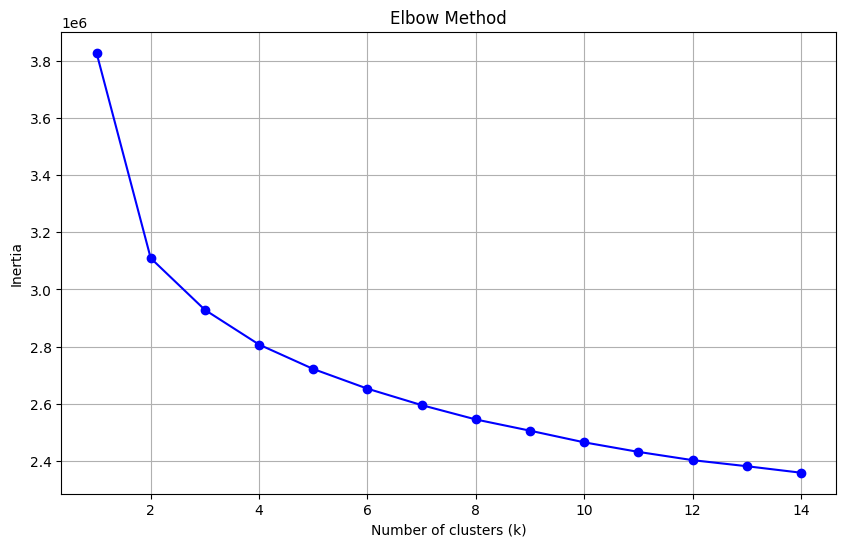

In [210]:
X = df_scaled[features_to_scale]

inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [211]:
# оптимальное число кластеров 2

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

kmeans.fit(X)
X.head()

,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq,year,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,day_sin,day_cos,month_sin,month_cos
0,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.312503,0.0,0.000503,1.410646,0.000673,1.414824,0.293772,1.381991,0.284151,1.37651,0.0,1.110223e-16
1,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,1.383664,0.293325,0.284151,1.37651,0.0,1.110223e-16
2,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,1.414586,-0.000541,0.284151,1.37651,0.0,1.110223e-16
3,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.312503,0.0,0.000503,1.410646,0.000673,1.414824,0.831297,-1.144020,0.284151,1.37651,0.0,1.110223e-16
4,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,-0.000425,-1.413959,0.284151,1.37651,0.0,1.110223e-16


In [212]:
X.head()

,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq,year,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,day_sin,day_cos,month_sin,month_cos
0,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.312503,0.0,0.000503,1.410646,0.000673,1.414824,0.293772,1.381991,0.284151,1.37651,0.0,1.110223e-16
1,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,1.383664,0.293325,0.284151,1.37651,0.0,1.110223e-16
2,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,1.414586,-0.000541,0.284151,1.37651,0.0,1.110223e-16
3,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.312503,0.0,0.000503,1.410646,0.000673,1.414824,0.831297,-1.144020,0.284151,1.37651,0.0,1.110223e-16
4,0.689067,1.024764,-1.581014,-0.014603,-0.296571,0.296571,0.190922,0.280419,0.0,0.000503,1.410646,0.000673,1.414824,-0.000425,-1.413959,0.284151,1.37651,0.0,1.110223e-16


In [213]:
X.columns

Index(['octet1', 'octet2', 'octet3', 'octet4', 'http_method_GET',
       'http_method_POST', 'session_freq', 'endpoint_freq', 'year', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [214]:
# Предполагая, что у вас есть обученный scaler (например, StandardScaler)
# и модель кластеризации kmeans уже обучена

# Создаем копию данных без столбца кластера (если он есть)
if 'cluster' in X.columns:
    features_to_transform = X.drop('cluster', axis=1)
else:
    features_to_transform = X

# Применяем обратное преобразование scaler
X_original = pd.DataFrame(
    scaler.inverse_transform(features_to_transform),
    columns=features_to_transform.columns,
    index=X.index
)

# Добавляем столбец с кластерами обратно
X_original['cluster'] = kmeans.labels_

# Теперь X_original содержит данные в исходном масштабе
X_original.head()

,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq,year,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,day_sin,day_cos,month_sin,month_cos,cluster
0,179.0,203.0,10.0,126.0,0.0,1.0,9.0,110410.0,2015.0,5.421011e-20,1.0,0.0,1.0,2.079117e-01,9.781476e-01,0.201299,0.97953,0.5,0.866025,0
1,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,5.421011e-20,1.0,0.0,1.0,9.781476e-01,2.079117e-01,0.201299,0.97953,0.5,0.866025,0
2,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,5.421011e-20,1.0,0.0,1.0,1.000000e+00,2.833020e-16,0.201299,0.97953,0.5,0.866025,0
3,179.0,203.0,10.0,126.0,0.0,1.0,9.0,110410.0,2015.0,5.421011e-20,1.0,0.0,1.0,5.877853e-01,-8.090170e-01,0.201299,0.97953,0.5,0.866025,0
4,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,5.421011e-20,1.0,0.0,1.0,5.665498e-16,-1.000000e+00,0.201299,0.97953,0.5,0.866025,0


In [215]:
X_original['cluster'].value_counts()

,count
cluster,
0,219864
1,19338


In [219]:
# Восстановление часов
X_original['hour_reconstructed'] = np.arctan2(X_original['hour_sin'], X_original['hour_cos']) * 24 / (2 * np.pi)
X_original['hour_reconstructed'] = X_original['hour_reconstructed'] % 24
X_original['hour_reconstructed'] = X_original['hour_reconstructed'].round().astype(int)

# Восстановление минут
X_original['minute_reconstructed'] = np.arctan2(X_original['minute_sin'], X_original['minute_cos']) * 60 / (2 * np.pi)
X_original['minute_reconstructed'] = X_original['minute_reconstructed'] % 60
X_original['minute_reconstructed'] = X_original['minute_reconstructed'].round().astype(int)

# Восстановление секунд
X_original['second_reconstructed'] = np.arctan2(X_original['second_sin'], X_original['second_cos']) * 60 / (2 * np.pi)
X_original['second_reconstructed'] = X_original['second_reconstructed'] % 60
X_original['second_reconstructed'] = X_original['second_reconstructed'].round().astype(int)

# Восстановление месяцев
X_original['month_reconstructed'] = np.arctan2(X_original['month_sin'], X_original['month_cos']) * 12 / (2 * np.pi)
X_original['month_reconstructed'] = X_original['month_reconstructed'] % 12
X_original['month_reconstructed'] = X_original['month_reconstructed'].round().astype(int)
# Месяцы от 1 до 12 (вместо 0-11)
X_original['month_reconstructed'] = X_original['month_reconstructed'].replace(0, 12)

In [220]:
X_original.head()

,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq,year,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,day_sin,day_cos,month_sin,month_cos,cluster,hour_reconstructed,minute_reconstructed,second_reconstructed,month_reconstructed
0,179.0,203.0,10.0,126.0,0.0,1.0,9.0,110410.0,2015.0,5.421011e-20,1.0,0.0,1.0,2.079117e-01,9.781476e-01,0.201299,0.97953,0.5,0.866025,0,0,0,2,1
1,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,5.421011e-20,1.0,0.0,1.0,9.781476e-01,2.079117e-01,0.201299,0.97953,0.5,0.866025,0,0,0,13,1
2,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,5.421011e-20,1.0,0.0,1.0,1.000000e+00,2.833020e-16,0.201299,0.97953,0.5,0.866025,0,0,0,15,1
3,179.0,203.0,10.0,126.0,0.0,1.0,9.0,110410.0,2015.0,5.421011e-20,1.0,0.0,1.0,5.877853e-01,-8.090170e-01,0.201299,0.97953,0.5,0.866025,0,0,0,24,1
4,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,5.421011e-20,1.0,0.0,1.0,5.665498e-16,-1.000000e+00,0.201299,0.97953,0.5,0.866025,0,0,0,30,1


In [221]:
# Если в X_original есть timestamp для точного восстановления дней
if 'timestamp' in X_original.columns:
    days_in_month = X_original['timestamp'].dt.days_in_month
    X_original['day_reconstructed'] = np.arctan2(X_original['day_sin'], X_original['day_cos']) * days_in_month / (2 * np.pi)
    X_original['day_reconstructed'] = X_original['day_reconstructed'] % days_in_month
    X_original['day_reconstructed'] = X_original['day_reconstructed'].round().astype(int)
else:
    # Альтернативный подход - используем среднее количество дней (30)
    X_original['day_reconstructed'] = np.arctan2(X_original['day_sin'], X_original['day_cos']) * 30 / (2 * np.pi)
    X_original['day_reconstructed'] = X_original['day_reconstructed'] % 30
    X_original['day_reconstructed'] = X_original['day_reconstructed'].round().astype(int)
    print("Для восстановления дней использовано среднее значение 30 дней в месяце")

Для восстановления дней использовано среднее значение 30 дней в месяце


In [222]:
# Удаляем временные синус/косинус признаки
time_sin_cos_cols = ['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
                    'second_sin', 'second_cos', 'day_sin', 'day_cos',
                    'month_sin', 'month_cos']
X_original = X_original.drop(columns=time_sin_cos_cols, errors='ignore')

In [223]:
X_original

,octet1,octet2,octet3,octet4,http_method_GET,http_method_POST,session_freq,endpoint_freq,year,cluster,hour_reconstructed,minute_reconstructed,second_reconstructed,month_reconstructed,day_reconstructed
0,179.0,203.0,10.0,126.0,0.0,1.0,9.0,110410.0,2015.0,0,0,0,2,1,1
1,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,0,0,0,13,1,1
2,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,0,0,0,15,1,1
3,179.0,203.0,10.0,126.0,0.0,1.0,9.0,110410.0,2015.0,0,0,0,24,1,1
4,179.0,203.0,10.0,126.0,0.0,1.0,9.0,109454.0,2015.0,0,0,0,30,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239197,121.0,64.0,17.0,46.0,0.0,1.0,14.0,110410.0,2015.0,0,23,59,40,1,30
239198,13.0,190.0,220.0,64.0,0.0,1.0,1.0,109454.0,2015.0,0,23,59,47,1,30
239199,121.0,64.0,17.0,46.0,0.0,1.0,14.0,109454.0,2015.0,0,23,59,51,1,30
239200,2.0,57.0,156.0,197.0,0.0,1.0,1.0,109454.0,2015.0,0,23,59,56,1,30
